In [1]:
%matplotlib inline
import os
import sys
import re
import copy
import numpy as np
import pickle
from scipy.optimize import fmin
import multiprocessing as mp
import functools
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
from itertools import product
from scipy.optimize import minimize

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# statmech library setup
sys.path.append('../../statmechlib')
from statmechlib.preprocessing import select_nodes, to_param_dict, to_param_list, tpf_to_bsplines
from statmechlib.preprocessing import Trajectory, scale_configuration, pair_dist_cutoff, find_index
from statmechlib.preprocessing import universal_eos, downselect
from statmechlib.read_write import params_to_pickle
from statmechlib.forcefields import u_core, penalty_matrix, make_input_matrices, make_input_matrices_forces
from statmechlib.forcefields import f_embed, f_dens, f_spline3, energy
from statmechlib.forcefields import loss_energy_penalized, jacobian_energy_penalized
from statmechlib.forcefields import loss_sd2_penalized, jacobian_sd2_penalized
from statmechlib.forcefields import loss_sd2f_penalized

In [4]:
working = '../data/working'

In [5]:
# params_file = 'marinica_params'
# with open(os.path.join(working, params_file + '.pickle'), 'rb') as fi:
#     param_list = pickle.load(fi)  

In [6]:
params_file = 'marinica_bs'
with open(os.path.join(working, params_file + '.pickle'), 'rb') as fi:
    param_list = pickle.load(fi)

In [7]:
file_name = os.path.join(working, "params_final_from_marica.pickle")

with open(file_name, 'rb') as fi:
    params_store = pickle.load(fi)

In [8]:
binom = [1.0, -4.0, 6.0, -4.0, 1.0]

def make_bspline(coeffs, k, r):
    """
    Calculate energy from a cubic b-spline-based potential
    """
    
    u = 0.0
    for i, c in enumerate(coeffs):        
        for j, b in enumerate(binom):
            # truncated polynomial basis function
            tpf = (k[i+j]-r)**3 if r < k[i+j] else 0.0
            
            # contribution to potential from a b-spline basis function component
            u += c*b*tpf
            #u += c*b*tpf(r, k[i+j])
        
    return u

In [9]:
stats_file = 'stats_bs_force_samples' # 'stats_samples'
with open(os.path.join(working, stats_file+'.pickle'), 'rb') as fi:
    stats_tpf = pickle.load(fi, encoding='latin1')

stats_bspline = tpf_to_bsplines(stats_tpf)

target_file = 'target_bs_force_samples'
with open(os.path.join(working, target_file+'.pickle'), 'rb') as fi:
    targets = pickle.load(fi, encoding='latin1')

len 50


In [10]:
targets['eos']['box'] = targets['eos']['box'][0:1]
targets['eos']['xyz'] = targets['eos']['xyz'][0:1]
targets['eos']['temp'] = targets['eos']['temp'][0:1]
targets['eos']['beta'] = targets['eos']['beta'][0:1]
targets['eos']['energy'] = targets['eos']['energy'][0:1]
stats_bspline['eos']['energy'] = stats_bspline['eos']['energy'][0:1]
stats_bspline['eos']['forces'] = stats_bspline['eos']['forces'][0:1]

In [11]:
targets['eos_bcc']['box'] = targets['eos_bcc']['box'][1:4]
targets['eos_bcc']['xyz'] = targets['eos_bcc']['xyz'][1:4]
targets['eos_bcc']['temp'] = targets['eos_bcc']['temp'][1:4]
targets['eos_bcc']['beta'] = targets['eos_bcc']['beta'][1:4]
targets['eos_bcc']['energy'] = targets['eos_bcc']['energy'][1:4]
stats_bspline['eos_bcc']['energy'] = stats_bspline['eos_bcc']['energy'][1:4]
stats_bspline['eos_bcc']['forces'] = stats_bspline['eos_bcc']['forces'][1:4]

In [12]:
targets['relax']['box'][1] = targets['inf']['box'][0]
targets['relax']['xyz'][1] = targets['inf']['xyz'][0]
targets['relax']['temp'][1] = targets['inf']['temp'][0]
targets['relax']['beta'][1] = targets['inf']['beta'][0]
targets['relax']['energy'][1] = targets['inf']['energy'][0]
stats_bspline['relax']['energy'][1] = stats_bspline['inf']['energy'][0]
stats_bspline['relax']['forces'][1] = stats_bspline['inf']['forces'][0]

In [13]:
edens_knots = list(np.linspace(1.05, 4.55, 36))
pair_knots = list(np.linspace(1.05, 5.25, 43))

print(edens_knots)
print(pair_knots)

stats_list = [downselect(stats_bspline, pair_knots, edens_knots, bspline=True)]

[1.05, 1.1500000000000001, 1.25, 1.35, 1.4500000000000002, 1.55, 1.6500000000000001, 1.75, 1.85, 1.9500000000000002, 2.05, 2.1500000000000004, 2.25, 2.35, 2.45, 2.55, 2.6500000000000004, 2.75, 2.85, 2.95, 3.05, 3.1500000000000004, 3.25, 3.3500000000000005, 3.45, 3.55, 3.6500000000000004, 3.75, 3.8500000000000005, 3.95, 4.05, 4.15, 4.25, 4.3500000000000005, 4.45, 4.55]
[1.05, 1.1500000000000001, 1.25, 1.35, 1.4500000000000002, 1.55, 1.6500000000000001, 1.75, 1.85, 1.9500000000000002, 2.05, 2.1500000000000004, 2.25, 2.35, 2.45, 2.55, 2.6500000000000004, 2.75, 2.85, 2.95, 3.05, 3.1500000000000004, 3.25, 3.3500000000000005, 3.45, 3.55, 3.6500000000000004, 3.75, 3.8500000000000005, 3.95, 4.05, 4.15, 4.25, 4.3500000000000005, 4.45, 4.55, 4.65, 4.75, 4.8500000000000005, 4.95, 5.05, 5.15, 5.25]


In [14]:
tkeys = ['bcc_npt_langevin_300K',
 'bcc_npt_langevin_3700K',
 'fcc_npt_langevin_300K',
 'vac_npt_langevin_2000K',
 'i110_npt_langevin_2000K',
 'i111_npt_langevin_2000K',
 'screw_111_npt_langevin_2000K',
 'liq_3700K',
 'liq_5000K',
 'eos',
 'eos_bcc',
 'eos_fcc',
 'vacint',
 'bain',
 'relax']

In [15]:
targets['eos_fcc']['weight'] = 0.0
targets['bain']['weight'] = 0.003 #0.1
targets['eos']['weight'] = 0.0 #1e-4
targets['eos_bcc']['weight'] = 0.003 #0.1
targets['relax']['weight'] = 4.0
targets['inf']['weight'] = 0.0
targets['vacint']['weight'] = 0.0
targets['fcc_npt_langevin_300K']['weight'] = 1.0
targets['bcc_npt_langevin_300K']['weight'] = 5.0
targets['bcc_npt_langevin_3700K']['weight'] = 3.0
# targets['screw_111_npt_langevin_2000K']['weight'] = 0.0
# targets['vac_npt_langevin_2000K']['weight'] = 0.0
# targets['i111_npt_langevin_2000K']['weight'] = 0.0
# targets['i110_npt_langevin_2000K']['weight'] = 0.0

targets['eos']['temp'][0] = 10000.0
targets['eos']['energy'][0] = 20000.0

for tmp in targets['eos_bcc']['temp']:
    tmp = 10000.0
for tmp in targets['eos_bcc']['beta']:
    tmp = 1./10000.0
    
for tmp in targets['bain']['temp']:
    tmp = 10000.0
for tmp in targets['bain']['beta']:
    tmp = 1./10000.0
#targets['eos']['energy']

#targets['liq_5000K']['weight'] = 0.1
[(key, targets[key]['weight']) for key in targets.keys()]

[('bcc_npt_langevin_3700K', 3.0),
 ('liq_5000K', 1.0),
 ('vac_npt_langevin_2000K', 1.0),
 ('relax', 4.0),
 ('screw_111_npt_langevin_2000K', 1.0),
 ('i110_npt_langevin_2000K', 1.0),
 ('bcc_npt_langevin_300K', 5.0),
 ('i111_npt_langevin_2000K', 1.0),
 ('eos', 0.0),
 ('fcc_npt_langevin_300K', 1.0),
 ('vacint', 0.0),
 ('eos_fcc', 0.0),
 ('inf', 0.0),
 ('liq_3700K', 1.0),
 ('eos_bcc', 0.003),
 ('bain', 0.003)]

In [16]:
dl_dict = {key:0.0 for key in tkeys}
dl_dict['relax'] = 1.0
dl_dict['bcc_npt_langevin_300K'] = 1.0
# dl_dict['bcc_npt_langevin_3700K'] = 0.03
dl_dict['vac_npt_langevin_2000K'] = 1.0
# dl_dict['screw_111_npt_langevin_2000K'] = 0.03
dl_dict['i111_npt_langevin_2000K'] = 1.0
dl_dict['i110_npt_langevin_2000K'] = 1.0
#dl_dict['liq_3700K'] = 0.01
#dl_dict['eos_bcc'] = 0.1
#dl_dict['bain'] = 0.1
dl_list = [dl_dict[key] for key in tkeys]

In [17]:
[(k,d) for k, d in zip(dl_list, tkeys)]

[(1.0, 'bcc_npt_langevin_300K'),
 (0.0, 'bcc_npt_langevin_3700K'),
 (0.0, 'fcc_npt_langevin_300K'),
 (1.0, 'vac_npt_langevin_2000K'),
 (1.0, 'i110_npt_langevin_2000K'),
 (1.0, 'i111_npt_langevin_2000K'),
 (0.0, 'screw_111_npt_langevin_2000K'),
 (0.0, 'liq_3700K'),
 (0.0, 'liq_5000K'),
 (0.0, 'eos'),
 (0.0, 'eos_bcc'),
 (0.0, 'eos_fcc'),
 (0.0, 'vacint'),
 (0.0, 'bain'),
 (1.0, 'relax')]

## SD matching

**Parameters optimized only on energetics**

In [29]:
b_init = np.array([-1.77236945e-05,  4.82923750e+03,  4.22066944e+03,  3.65746164e+03,
        3.13964314e+03,  2.66710984e+03,  2.23960432e+03,  1.85663747e+03,
        1.51734030e+03,  1.22048619e+03,  9.64385734e+02,  7.46855155e+02,
        5.65250119e+02,  4.16686790e+02,  2.98530275e+02,  2.08598096e+02,
        1.43436584e+02,  9.77225071e+01,  6.77334783e+01,  4.98964693e+01,
        4.04640480e+01,  3.68202368e+01,  3.66445646e+01,  3.78780939e+01,
        3.92254100e+01,  4.00633191e+01,  3.98164560e+01,  3.81964789e+01,
        3.53574057e+01,  3.10575775e+01,  2.55451101e+01,  1.91626397e+01,
        1.25152874e+01,  7.03408097e+00,  2.98947809e+00,  7.80805866e-01,
        8.43725527e-01,  2.46224801e+00,  3.65344444e+00,  2.95514255e+00,
        1.94656632e+00, -1.36276462e+00, 0.0, -1.32595598e+04, -7.95831705e+03,
       -3.41935203e+03,  3.58089542e+02,  3.37300793e+03,  5.62582912e+03,
        7.12823078e+03,  7.91257993e+03,  8.04037243e+03,  7.61145039e+03,
        6.77397091e+03,  5.73396034e+03,  4.72029679e+03,  3.85732910e+03,
        3.07281330e+03,  2.40139500e+03,  1.97515993e+03,  1.63324389e+03,
        1.37254472e+03,  1.22121660e+03,  1.09394470e+03,  9.60335237e+02,
        8.22116530e+02,  7.14330684e+02,  6.06332051e+02,  5.22848690e+02,
        4.65625132e+02,  3.82913221e+02,  3.20184358e+02,  2.44830689e+02,
        1.65405216e+02,  1.39560438e+02,  7.26746325e+01,  2.82409129e+01,
        1.46876318e+00])

b_init = np.array([-1.74160659e-05,  4.81792298e+03,  4.21102349e+03,  3.64920898e+03,
        3.13254040e+03,  2.66100468e+03,  2.23428733e+03,  1.85180718e+03,
        1.51276064e+03,  1.21602379e+03,  9.60229740e+02,  7.43559979e+02,
        5.63390477e+02,  4.16354960e+02,  2.99236995e+02,  2.09373880e+02,
        1.43343914e+02,  9.76615818e+01,  6.80717473e+01,  5.03817395e+01,
        4.05861314e+01,  3.67367709e+01,  3.64196643e+01,  3.73899757e+01,
        3.82714780e+01,  3.86028465e+01,  3.80978840e+01,  3.65532993e+01,
        3.40365270e+01,  3.03428118e+01,  2.55388072e+01,  1.95612423e+01,
        1.28676144e+01,  6.99529687e+00,  2.98651795e+00,  1.19493929e+00,
        1.00134492e+00,  2.32280112e+00,  3.62463065e+00,  3.13709663e+00,
        1.60517579e+00, -1.36544978e+00, -1.43038749e-01, 0.0, -1.32527064e+04,
       -7.75203159e+03, -3.10032051e+03,  7.07874911e+02,  3.68329967e+03,
        5.85314658e+03,  7.25022717e+03,  7.93423633e+03,  7.99510491e+03,
        7.54647572e+03,  6.72303757e+03,  5.71138575e+03,  4.72504875e+03,
        3.87474867e+03,  3.08167614e+03,  2.40349119e+03,  1.97390024e+03,
        1.64105106e+03,  1.37218087e+03,  1.21938836e+03,  1.09298828e+03,
        9.54949279e+02,  8.16358844e+02,  7.05161783e+02,  5.92566765e+02,
        5.05256983e+02,  4.48080867e+02,  3.72965933e+02,  3.21942254e+02,
        2.47543325e+02,  1.72063654e+02,  1.40805880e+02,  7.40130332e+01,
        2.78482427e+01,  6.64486213e+00])

b_init = np.array([-1.50666230e-05,  4.77211861e+03,  4.17864469e+03,  3.62851703e+03,
        3.12178782e+03,  2.65851221e+03,  2.23854754e+03,  1.86143178e+03,
        1.52633752e+03,  1.23201441e+03,  9.76809642e+02,  7.58713215e+02,
        5.75484024e+02,  4.24642377e+02,  3.03995939e+02,  2.11646010e+02,
        1.44405117e+02,  9.76710034e+01,  6.75600243e+01,  5.02934003e+01,
        4.16371550e+01,  3.87750297e+01,  3.86174140e+01,  3.89697094e+01,
        3.86641346e+01,  3.76506198e+01,  3.61589689e+01,  3.43514762e+01,
        3.23024057e+01,  2.94312350e+01,  2.53747936e+01,  1.99563292e+01,
        1.35511064e+01,  7.36849993e+00,  2.29467608e+00, -6.29186382e-01,
       -1.00747190e+00,  4.69994778e-01,  1.74355593e+00,  1.33064011e+00,
       -3.69063893e-03, -2.28465069e+00, -1.92697636e+00, -6.41251323e-01,
       -9.97040172e+03, -5.07481467e+03, -9.41165475e+02,  2.43146094e+03,
        5.04897625e+03,  6.92832335e+03,  8.10126509e+03,  8.61647632e+03,
        8.53868754e+03,  7.96186678e+03,  7.02712833e+03,  5.92473430e+03,
        4.85594943e+03,  3.92807361e+03,  3.09577803e+03,  2.40208017e+03,
        1.94123460e+03,  1.61275212e+03,  1.34998368e+03,  1.21645401e+03,
        1.08668950e+03,  9.72822867e+02,  8.37327964e+02,  7.07406437e+02,
        5.84528832e+02,  4.84579440e+02,  4.13615572e+02,  3.34344835e+02,
        2.92636479e+02,  2.42441970e+02,  1.87260093e+02,  1.50103585e+02,
        8.96204166e+01,  2.96443994e+01,  3.11656421e-01, 0.0])

b_init = np.array([-1.38841502e-05,  4.71216488e+03,  4.14070407e+03,  3.60892798e+03,
        3.11681713e+03,  2.66428818e+03,  2.25118546e+03,  1.87740946e+03,
        1.54272075e+03,  1.24673876e+03,  9.88796697e+02,  7.67772404e+02,
        5.81950614e+02,  4.29068044e+02,  3.06798039e+02,  2.12975723e+02,
        1.44342476e+02,  9.67176289e+01,  6.65991381e+01,  4.99246727e+01,
        4.20378191e+01,  3.96997614e+01,  4.00702720e+01,  4.12202941e+01,
        4.18691399e+01,  4.15099212e+01,  4.01650735e+01,  3.79410917e+01,
        3.48716952e+01,  3.06383240e+01,  2.53493960e+01,  1.92143427e+01,
        1.27474914e+01,  6.91139991e+00,  2.12214135e+00, -5.42340157e-01,
       -1.00713500e+00, -7.56746404e-02,  8.15744454e-01,  5.05842905e-01,
       -5.96811792e-01, -2.60848750e+00, -2.46129369e+00, -7.38254686e-01,
       -6.40404946e+03, -2.15068727e+03,  1.41947955e+03,  4.30737110e+03,
        6.51553426e+03,  8.05103368e+03,  8.93478576e+03,  9.21051517e+03,
        8.94770222e+03,  8.24357232e+03,  7.22600089e+03,  6.05892229e+03,
        4.93497322e+03,  3.96874851e+03,  3.11165905e+03,  2.40019520e+03,
        1.91866228e+03,  1.59206852e+03,  1.33172446e+03,  1.21122097e+03,
        1.09363986e+03,  9.90416650e+02,  8.64372921e+02,  7.37815077e+02,
        6.25964689e+02,  5.27317321e+02,  4.46245942e+02,  3.58228763e+02,
        2.99914989e+02,  2.37442367e+02,  1.79960268e+02,  1.45444961e+02,
        9.18633955e+01,  3.21023326e+01,  8.58199837e+00,  1.47383322e+01])

b_init = np.array([-1.35800621e-05,  4.70215187e+03,  4.13378121e+03,  3.60467087e+03,
        3.11479537e+03,  2.66409569e+03,  2.25250587e+03,  1.87983814e+03,
        1.54578894e+03,  1.24990604e+03,  9.91554187e+02,  7.69728340e+02,
        5.83036503e+02,  4.29526970e+02,  3.06985057e+02,  2.13171429e+02,
        1.44684610e+02,  9.71108455e+01,  6.67703679e+01,  4.98542529e+01,
        4.18305406e+01,  3.91276347e+01,  3.89211611e+01,  3.95902654e+01,
        4.01253284e+01,  4.00739681e+01,  3.94406977e+01,  3.81445658e+01,
        3.60155791e+01,  3.25574634e+01,  2.76272824e+01,  2.12266404e+01,
        1.38860247e+01,  6.99943883e+00,  2.00550045e+00, -5.02465234e-01,
       -8.34016479e-01, -3.51102716e-02,  6.59220117e-01,  4.03842433e-01,
       -7.65093435e-01, -2.76353353e+00, -2.67881720e+00, -8.85267119e-01,
        6.39605784e+02,  3.30730541e+03,  5.50899647e+03,  7.24391832e+03,
        8.51143103e+03,  9.31370845e+03,  9.66446612e+03,  9.58651387e+03,
        9.11423267e+03,  8.30477654e+03,  7.24639063e+03,  6.06938661e+03,
        4.94191356e+03,  3.96882382e+03,  3.11049686e+03,  2.40118129e+03,
        1.91893069e+03,  1.59103337e+03,  1.32761509e+03,  1.20567502e+03,
        1.08259121e+03,  9.73127591e+02,  8.45421954e+02,  7.20457190e+02,
        6.15659530e+02,  5.22207250e+02,  4.46603970e+02,  3.73194397e+02,
        3.29523025e+02,  2.72281839e+02,  2.08397091e+02,  1.61831346e+02,
        9.46547893e+01,  3.29578379e+01,  1.11647804e+01,  2.10061331e+01])

b_init = np.array([-1.36134900e-05,  4.70180731e+03,  4.13262813e+03,  3.60289582e+03,
        3.11262961e+03,  2.66185369e+03,  2.25053206e+03,  1.87849382e+03,
        1.54537932e+03,  1.25061648e+03,  9.93337108e+02,  7.72314627e+02,
        5.85833365e+02,  4.31743229e+02,  3.08059475e+02,  2.13334776e+02,
        1.44602940e+02,  9.70917396e+01,  6.69288591e+01,  5.00768808e+01,
        4.18478572e+01,  3.92693070e+01,  3.88416604e+01,  3.89284303e+01,
        3.86783962e+01,  3.79539656e+01,  3.69761245e+01,  3.57097345e+01,
        3.39124980e+01,  3.08689594e+01,  2.64013168e+01,  2.04546226e+01,
        1.35296046e+01,  7.04487343e+00,  2.02536553e+00, -6.86515488e-01,
       -1.11830900e+00, -1.51016487e-01,  6.56943476e-01,  2.94456632e-01,
       -6.95331334e-01, -2.81432091e+00, -2.55733805e+00, -8.42214471e-01,
        5.49303024e+02,  3.36151176e+03,  5.66702445e+03,  7.46530991e+03,
        8.75784303e+03,  9.55348192e+03,  9.87500550e+03,  9.75471064e+03,
        9.23975738e+03,  8.39522425e+03,  7.31081588e+03,  6.11314129e+03,
        4.96613006e+03,  3.97885647e+03,  3.11287606e+03,  2.39951868e+03,
        1.92092614e+03,  1.59107450e+03,  1.33136526e+03,  1.20612548e+03,
        1.08657079e+03,  9.75827881e+02,  8.39592251e+02,  7.02655327e+02,
        5.90152445e+02,  4.93703056e+02,  4.18167796e+02,  3.47259462e+02,
        3.07809053e+02,  2.55678973e+02,  1.97081725e+02,  1.58537913e+02,
        9.39419318e+01,  3.35958031e+01,  9.20361613e+00,  1.63180121e+01])

# this to Yury
b_init = np.array([-1.36064888e-05,  4.70417226e+03,  4.13423815e+03,  3.60397825e+03,
        3.11346024e+03,  2.66302750e+03,  2.25258846e+03,  1.88082365e+03,
        1.54697937e+03,  1.25083317e+03,  9.92104104e+02,  7.70968996e+02,
        5.86895530e+02,  4.33960550e+02,  3.08127025e+02,  2.13279363e+02,
        1.44599321e+02,  9.70922418e+01,  6.66420162e+01,  5.01808655e+01,
        4.18434145e+01,  3.92814989e+01,  3.88058201e+01,  3.90736696e+01,
        3.90564985e+01,  3.80019954e+01,  3.69774317e+01,  3.49288610e+01,
        3.44176478e+01,  3.07358626e+01,  2.65367220e+01,  2.09352894e+01,
        1.35480479e+01,  7.03962431e+00,  2.02979256e+00, -6.91721500e-01,
       -1.11666412e+00, -1.60434154e-01,  7.61189585e-01,  2.27605036e-01,
       -6.94012140e-01, -2.81527516e+00, -2.56153955e+00, -8.43675194e-01,
        5.81825516e+02,  3.38975948e+03,  5.69062175e+03,  7.48687373e+03,
        8.77886762e+03,  9.57937993e+03,  9.90743757e+03,  9.78902045e+03,
        9.26787183e+03,  8.41119988e+03,  7.32042822e+03,  6.12730166e+03,
        4.98085058e+03,  3.98051092e+03,  3.11287043e+03,  2.39949350e+03,
        1.92069903e+03,  1.58877343e+03,  1.33115727e+03,  1.20621620e+03,
        1.08635268e+03,  9.76230233e+02,  8.44241018e+02,  7.06348062e+02,
        5.89775524e+02,  4.90774560e+02,  4.15884397e+02,  3.51361562e+02,
        3.09195758e+02,  2.57059585e+02,  2.00819272e+02,  1.58469140e+02,
        9.39284706e+01,  3.36845322e+01,  9.21887615e+00,  1.63239560e+01])

# b_init = np.array([-1.69807370e-05,  4.71389335e+03,  4.13548276e+03,  3.59830905e+03,
#         3.10227256e+03,  2.64708651e+03,  2.23238324e+03,  1.85779252e+03,
#         1.52280975e+03,  1.22699256e+03,  9.69919298e+02,  7.50671459e+02,
#         5.67372584e+02,  4.17317061e+02,  2.98015738e+02,  2.09118713e+02,
#         1.44879596e+02,  9.72986260e+01,  6.39128499e+01,  4.40401161e+01,
#         3.90803612e+01,  4.56942321e+01,  5.62996573e+01,  6.34162958e+01,
#         6.45789223e+01,  5.92029721e+01,  5.10931775e+01,  3.99279675e+01,
#         2.85118409e+01,  1.76811585e+01,  8.89500771e+00,  2.20663525e+00,
#        -2.92066801e-01,  3.71320657e+00,  7.34742875e+00,  7.61327378e+00,
#         4.93633966e+00,  2.75426201e+00,  2.25574331e+00,  1.10781587e-01,
#         1.39361435e+00, -2.13675818e+00,  2.64565761e-02,  1.02864527e+00,
#         5.52587371e+03,  7.36111895e+03,  8.78727584e+03,  9.80300665e+03,
#         1.04099615e+04,  1.06170787e+04,  1.04469168e+04,  9.93892941e+03,
#         9.14818977e+03,  8.14242386e+03,  6.99953947e+03,  5.82323585e+03,
#         4.74401468e+03,  3.84281653e+03,  3.03788063e+03,  2.40063461e+03,
#         1.95301222e+03,  1.55607977e+03,  1.29617202e+03,  1.18963020e+03,
#         1.18590378e+03,  1.17819603e+03,  1.11260859e+03,  9.70566407e+02,
#         8.35034424e+02,  6.27189677e+02,  4.62804912e+02,  2.90511402e+02,
#         1.50264260e+02,  2.76814291e+01, -7.99883889e+00,  3.25729970e+01,
#         5.14719601e+01,  9.48266065e+01,  1.19672628e+02,  5.94823384e+01])

# b_init = np.array([-1.74401102e-05,  4.72045469e+03,  4.13538142e+03,  3.59239596e+03,
#         3.09150695e+03,  2.63277478e+03,  2.21609165e+03,  1.84118204e+03,
#         1.50761176e+03,  1.21461688e+03,  9.61071364e+02,  7.45320796e+02,
#         5.64997393e+02,  4.17011167e+02,  2.98796085e+02,  2.09553202e+02,
#         1.43750399e+02,  9.45466686e+01,  6.33314807e+01,  4.65216097e+01,
#         4.25347271e+01,  4.73132058e+01,  5.55399894e+01,  6.17414586e+01,
#         6.30389124e+01,  5.86455416e+01,  5.10633060e+01,  3.96432588e+01,
#         2.74790500e+01,  1.59067699e+01,  6.36842472e+00, -5.51169799e-01,
#        -2.15526073e+00,  3.99780024e+00,  9.59546438e+00,  1.04873023e+01,
#         7.51945649e+00,  3.70402560e+00,  2.36595187e+00,  3.40042164e-01,
#         1.49514727e+00, -2.12302566e+00, -3.21815518e-03,  7.73334397e-01,
#         8.28146546e+03,  9.17487403e+03,  9.82857292e+03,  1.02422771e+04,
#         1.04167798e+04,  1.03527358e+04,  1.00548042e+04,  9.53391658e+03,
#         8.80946467e+03,  7.91449119e+03,  6.89950266e+03,  5.83439393e+03,
#         4.80642992e+03,  3.88206200e+03,  3.06501910e+03,  2.40649749e+03,
#         1.93435747e+03,  1.55997071e+03,  1.33093846e+03,  1.22885416e+03,
#         1.19800118e+03,  1.15824797e+03,  1.07706870e+03,  9.55555543e+02,
#         8.11137134e+02,  6.26058134e+02,  4.54258945e+02,  2.75593505e+02,
#         1.10345601e+02, -1.72289211e+01, -5.43871923e+01, -9.15824922e+00,
#         3.67731140e+01,  1.06837716e+02,  1.39689129e+02,  7.82227577e+01])

# b_init = np.array([-1.74401102e-05,  4.72045469e+03,  4.13538142e+03,  3.59239596e+03,
#         3.09150695e+03,  2.63277478e+03,  2.21609165e+03,  1.84118204e+03,
#         1.50761176e+03,  1.21461688e+03,  9.61071364e+02,  7.45320796e+02,
#         5.64997393e+02,  4.17011167e+02,  2.98796085e+02,  2.09553202e+02,
#         1.43750399e+02,  9.45466686e+01,  6.33314807e+01,  4.65216097e+01,
#         4.25347271e+01,  4.73132058e+01,  5.55399894e+01,  6.17414586e+01,
#         6.30389124e+01,  5.86455416e+01,  5.10633060e+01,  3.96432588e+01,
#         2.74790500e+01,  1.59067699e+01,  6.36842472e+00, -5.51169799e-01,
#        -2.15526073e+00,  3.99780024e+00,  9.59546438e+00,  1.04873023e+01,
#         7.51945649e+00,  3.70402560e+00,  2.36595187e+00,  3.40042164e-01,
#         1.49514727e+00, -2.12302566e+00, -3.21815518e-03,  7.73334397e-01,
#         1.08e4, 1.07e4, 1.06e4,  1.05422771e+04,
#         1.04167798e+04,  1.03527358e+04,  1.00548042e+04,  9.53391658e+03,
#         8.80946467e+03,  7.91449119e+03,  6.89950266e+03,  5.83439393e+03,
#         4.80642992e+03,  3.88206200e+03,  3.06501910e+03,  2.40649749e+03,
#         1.93435747e+03,  1.55997071e+03,  1.33093846e+03,  1.22885416e+03,
#         1.19800118e+03,  1.15824797e+03,  1.07706870e+03,  9.55555543e+02,
#         8.11137134e+02,  6.26058134e+02,  4.54258945e+02,  2.75593505e+02,
#         1.10345601e+02, -1.72289211e+01, -5.43871923e+01, -9.15824922e+00,
#         3.67731140e+01,  1.06837716e+02,  1.39689129e+02,  7.82227577e+01])

# b_init = np.array([-1.59500061e-05,  4.70181796e+03,  4.11458248e+03,  3.56993897e+03,
#         3.06792563e+03,  2.60855106e+03,  2.19164573e+03,  1.81701390e+03,
#         1.48436502e+03,  1.19298420e+03,  9.41818019e+02,  7.29222240e+02,
#         5.52866219e+02,  4.09584875e+02,  2.96192141e+02,  2.10706212e+02,
#         1.47422155e+02,  9.87493381e+01,  6.61617279e+01,  4.68800167e+01,
#         3.96301718e+01,  4.16616820e+01,  4.82100019e+01,  5.43292446e+01,
#         5.70305907e+01,  5.55841240e+01,  5.16692275e+01,  4.49864828e+01,
#         3.70119009e+01,  2.80557087e+01,  1.89617881e+01,  1.01263740e+01,
#         4.18213719e+00,  3.73753874e+00,  3.30668422e+00,  1.50886512e+00,
#         6.53698325e-01,  7.36010489e-01,  3.62542892e-02, -1.93852683e+00,
#         3.20298768e-01, -3.12601605e+00, -1.18901093e+00,  8.55034562e-02,
#         1.39292345e+04,  1.36611910e+04,  1.32922991e+04,  1.28223777e+04,
#         1.22496993e+04,  1.15720460e+04,  1.07856488e+04,  9.89269358e+03,
#         8.90634751e+03,  7.85063057e+03,  6.76134491e+03,  5.68693058e+03,
#         4.68515858e+03,  3.79939945e+03,  3.02754378e+03,  2.40392736e+03,
#         1.93613393e+03,  1.55350686e+03,  1.30001690e+03,  1.17380540e+03,
#         1.12238761e+03,  1.07956443e+03,  1.00412690e+03,  8.97874000e+02,
#         7.77090381e+02,  6.35547493e+02,  5.05137990e+02,  3.70479974e+02,
#         2.42028940e+02,  1.28892462e+02,  7.73556304e+01,  7.80344499e+01,
#         6.39072465e+01,  5.80698720e+01,  6.96192133e+01,  2.85872742e+01])

In [30]:
scale = np.ones((len(pair_knots)))*0.15
scale[-6:] *= 1.0
len(pair_knots), len(edens_knots), len(b_init)

(43, 36, 80)

In [31]:
alpha = 1.0

# 3rd order penalty for larger distances
partitions = []
partitions.append([1, None, None, None, None]) # Embedding function - no penalty
partitions.append([len(pair_knots), 3, scale, [], []])
partitions.append([len(edens_knots), 3, np.ones((len(edens_knots)))*0.01, [], []])

Dp3, Cp3, c3 = penalty_matrix(partitions)
print(c3, Cp3, Dp3[:])

results = []
for i, stat in enumerate(stats_list[-1:]):

    
    penalty_type = 'sd2_f'  #'energy'
    if penalty_type == 'energy':
        X, y, weight, beta, bounds = make_input_matrices(targets, stat, keytrj=tkeys)

        # assign weights to individual configurations
        weight_config = np.empty((len(y),), dtype=float)
        for i_trj, bound_slice in enumerate(bounds):
            weight_config[bound_slice] = weight[i_trj]

        loss = loss_energy_penalized
        jac = jacobian_energy_penalized
        args = (X, y, weight_config, Dp3, alpha)

    elif penalty_type == 'sd2_u':
        X, y, weight, beta, bounds = make_input_matrices(targets, stat, keytrj=tkeys, combined=0.35)

        loss = loss_sd2_penalized
        jac = jacobian_sd2_penalized
        alpha *= 1e-8
        # add an extra total trajectory
        #weight = np.append(weight, np.array([1.0]))
        #bounds = np.append(bounds, np.array(slice(0, len(y), 1)))
        args = (X, y, weight, bounds, beta, Dp3, alpha)
    elif penalty_type == 'sd2_f':
        X, y, weight, beta, dl, bounds, force_atoms = make_input_matrices_forces(targets, stat, keytrj=tkeys, combined=0.35, dl_dict=dl_dict)
        print('wdl', len(weight), len(dl))
        loss = loss_sd2f_penalized
        #jac = jacobian_sd2_penalized
        alpha *= 1e-8
        # add an extra total trajectory
        #weight = np.append(weight, np.array([1.0]))
        #bounds = np.append(bounds, np.array(slice(0, len(y), 1)))
        args = (X, y, weight, bounds, beta, dl, force_atoms, Dp3, alpha)
    
    #results.append(minimize(loss, b_init, args=args, jac=jac, options={'maxiter':10000}))
    #results.append(minimize(loss, b_init, args=args, options={'maxiter':10000}))
    results.append(minimize(loss, b_init, args=args, method='Nelder-Mead', options={'maxiter':3000}))

    #results.append(minimize(loss_energy_penalized, b_init, args=(X, y, weight, Dp3, alpha), jac=jacobian_energy_penalized, options={'maxiter':10000}))


0.0 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.] [[ 0.00e+00  0.00e+00  0.00e+00 ...  0.00e+00  0.00e+00  0.00e+00]
 [ 0.00e+00  2.25e-02 -6.75e-02 ...  0.00e+00  0.00e+00  0.00e+00]
 [ 0.00e+00 -6.75e-02  2.25e-01 ...  0.00e+00  0.00e+00  0.00e+00]
 ...
 [ 0.00e+00  0.00e+00  0.00e+00 ...  1.90e-03 -1.20e-03  3.00e-04]
 [ 0.00e+00  0.00e+00  0.00e+00 ... -1.20e-03  1.00e-03 -3.00e-04]
 [ 0.00e+00  0.00e+00  0.00e+00 ...  3.00e-04 -3.00e-04  1.00e-04]]
lens forces 200 200 200 200
lens forces 146 146 146 146
lens forces 126 126 126 126
lens forces 236 236 236 236
lens forces 133 133 133 133
lens forces 136 136 136 136
lens forces 199 199 199 199
lens forces 91 91 91 91
lens forces 122 122 122 122
lens forces 3 8 3 3
lens forces 12 12 12 12
lens forces 6 6 6 6
bounds [slice(0, 200, 1), slice

KeyboardInterrupt: 

In [552]:
results[-1]['x']

array([-1.59500061e-05,  4.70181796e+03,  4.11458248e+03,  3.56993897e+03,
        3.06792563e+03,  2.60855106e+03,  2.19164573e+03,  1.81701390e+03,
        1.48436502e+03,  1.19298420e+03,  9.41818019e+02,  7.29222240e+02,
        5.52866219e+02,  4.09584875e+02,  2.96192141e+02,  2.10706212e+02,
        1.47422155e+02,  9.87493381e+01,  6.61617279e+01,  4.68800167e+01,
        3.96301718e+01,  4.16616820e+01,  4.82100019e+01,  5.43292446e+01,
        5.70305907e+01,  5.55841240e+01,  5.16692275e+01,  4.49864828e+01,
        3.70119009e+01,  2.80557087e+01,  1.89617881e+01,  1.01263740e+01,
        4.18213719e+00,  3.73753874e+00,  3.30668422e+00,  1.50886512e+00,
        6.53698325e-01,  7.36010489e-01,  3.62542892e-02, -1.93852683e+00,
        3.20298768e-01, -3.12601605e+00, -1.18901093e+00,  8.55034562e-02,
        1.39292345e+04,  1.36611910e+04,  1.32922991e+04,  1.28223777e+04,
        1.22496993e+04,  1.15720460e+04,  1.07856488e+04,  9.89269358e+03,
        8.90634751e+03,  

In [553]:
#b_all = b_final
#b_force = b_force

b_all = results[-1]['x']
#b_all = b_init
b_all


array([-1.59500061e-05,  4.70181796e+03,  4.11458248e+03,  3.56993897e+03,
        3.06792563e+03,  2.60855106e+03,  2.19164573e+03,  1.81701390e+03,
        1.48436502e+03,  1.19298420e+03,  9.41818019e+02,  7.29222240e+02,
        5.52866219e+02,  4.09584875e+02,  2.96192141e+02,  2.10706212e+02,
        1.47422155e+02,  9.87493381e+01,  6.61617279e+01,  4.68800167e+01,
        3.96301718e+01,  4.16616820e+01,  4.82100019e+01,  5.43292446e+01,
        5.70305907e+01,  5.55841240e+01,  5.16692275e+01,  4.49864828e+01,
        3.70119009e+01,  2.80557087e+01,  1.89617881e+01,  1.01263740e+01,
        4.18213719e+00,  3.73753874e+00,  3.30668422e+00,  1.50886512e+00,
        6.53698325e-01,  7.36010489e-01,  3.62542892e-02, -1.93852683e+00,
        3.20298768e-01, -3.12601605e+00, -1.18901093e+00,  8.55034562e-02,
        1.39292345e+04,  1.36611910e+04,  1.32922991e+04,  1.28223777e+04,
        1.22496993e+04,  1.15720460e+04,  1.07856488e+04,  9.89269358e+03,
        8.90634751e+03,  

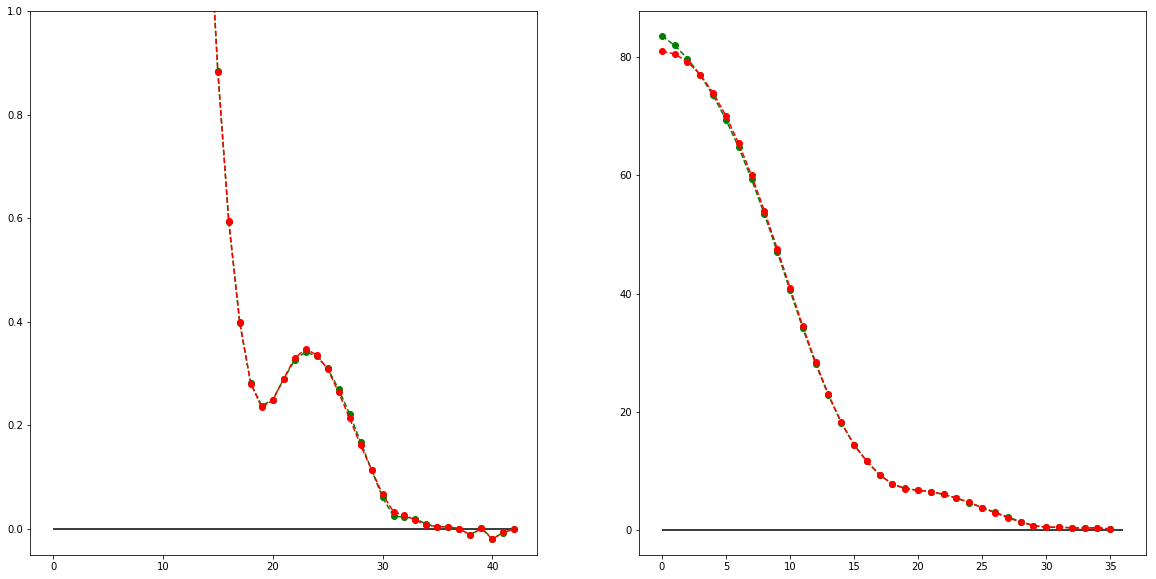

In [554]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(20,10))
axs[0].plot(np.array(b_all[1:1+len(pair_knots)])*(6*0.1**3) , 'go--')
axs[0].plot(np.array(b_init[1:1+len(pair_knots)])*(6*0.1**3) , 'ro--')

axs[0].set_ylim(-0.05,1.0)
axs[0].hlines(0.0, 0, 42)
axs[1].plot(np.array(b_all[1+len(pair_knots):])*(6*0.1**3) , 'go--')
axs[1].plot(np.array(b_init[1+len(pair_knots):])*(6*0.1**3) , 'ro--')
axs[1].hlines(0.0, 0, 36)

13
[slice(0, 200, 1), slice(200, 346, 1), slice(346, 472, 1), slice(472, 708, 1), slice(708, 841, 1), slice(841, 977, 1), slice(977, 1176, 1), slice(1176, 1267, 1), slice(1267, 1389, 1), slice(1389, 1392, 1), slice(1392, 1404, 1), slice(1404, 1410, 1), slice(0, 1610, 1)]
[-1139.189, 0.0, -1136.427, -1136.762, -1190.324, -1127.197]
[-1139.2, -0.0, -1136.401, -1136.751, -1190.261, -1127.175]


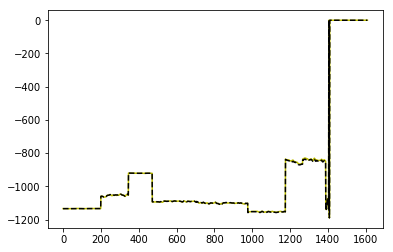

In [555]:
plt.plot(energy(b_all, X), 'y')
plt.plot(y[:,0], 'k--')
print(len(bounds))
print(bounds)
print([round(z, 3) for z in energy(b_all, X)[bounds[-2]]])
print([round(z, 3) for z in y[bounds[-2],0]])

In [556]:
stats_file = 'stats_bs_force_samples' # 'stats_samples'
with open(os.path.join(working, stats_file+'.pickle'), 'rb') as fi:
    stats_tpfx = pickle.load(fi, encoding='latin1')

stats_bsplinex = tpf_to_bsplines(stats_tpfx)

target_file = 'target_bs_force_samples'
with open(os.path.join(working, target_file+'.pickle'), 'rb') as fi:
    targetsx = pickle.load(fi, encoding='latin1')

len 50


In [557]:
stats_listx = [downselect(stats_bsplinex, pair_knots, edens_knots, bspline=True)]

for key in targets.keys():
    targetsx[key]['weight'] = 1.0
    
for i, stat in enumerate(stats_listx[-1:]):
    Xall, yall, weights, beta, dl, bounds, force_atoms = make_input_matrices_forces(targetsx, stat, keytrj=tkeys, combined=0.35, dl_dict=dl_dict)
    
    #Xall, yall, weights, beta, bounds = make_input_matrices(targetsx, stat, keytrj=tkeys)
    

lens forces 200 200 200 200
lens forces 146 146 146 146
lens forces 126 126 126 126
lens forces 236 236 236 236
lens forces 133 133 133 133
lens forces 136 136 136 136
lens forces 199 199 199 199
lens forces 91 91 91 91
lens forces 122 122 122 122
lens forces 21 21 21 21
lens forces 8 8 8 8
lens forces 8 8 8 8
lens forces 10 10 10 10
lens forces 12 12 12 12
lens forces 6 6 6 6
bounds [slice(0, 200, 1), slice(200, 346, 1), slice(346, 472, 1), slice(472, 708, 1), slice(708, 841, 1), slice(841, 977, 1), slice(977, 1176, 1), slice(1176, 1267, 1), slice(1267, 1389, 1), slice(1389, 1410, 1), slice(1410, 1418, 1), slice(1418, 1426, 1), slice(1426, 1436, 1), slice(1436, 1448, 1), slice(1448, 1454, 1), slice(0, 1654, 1)]


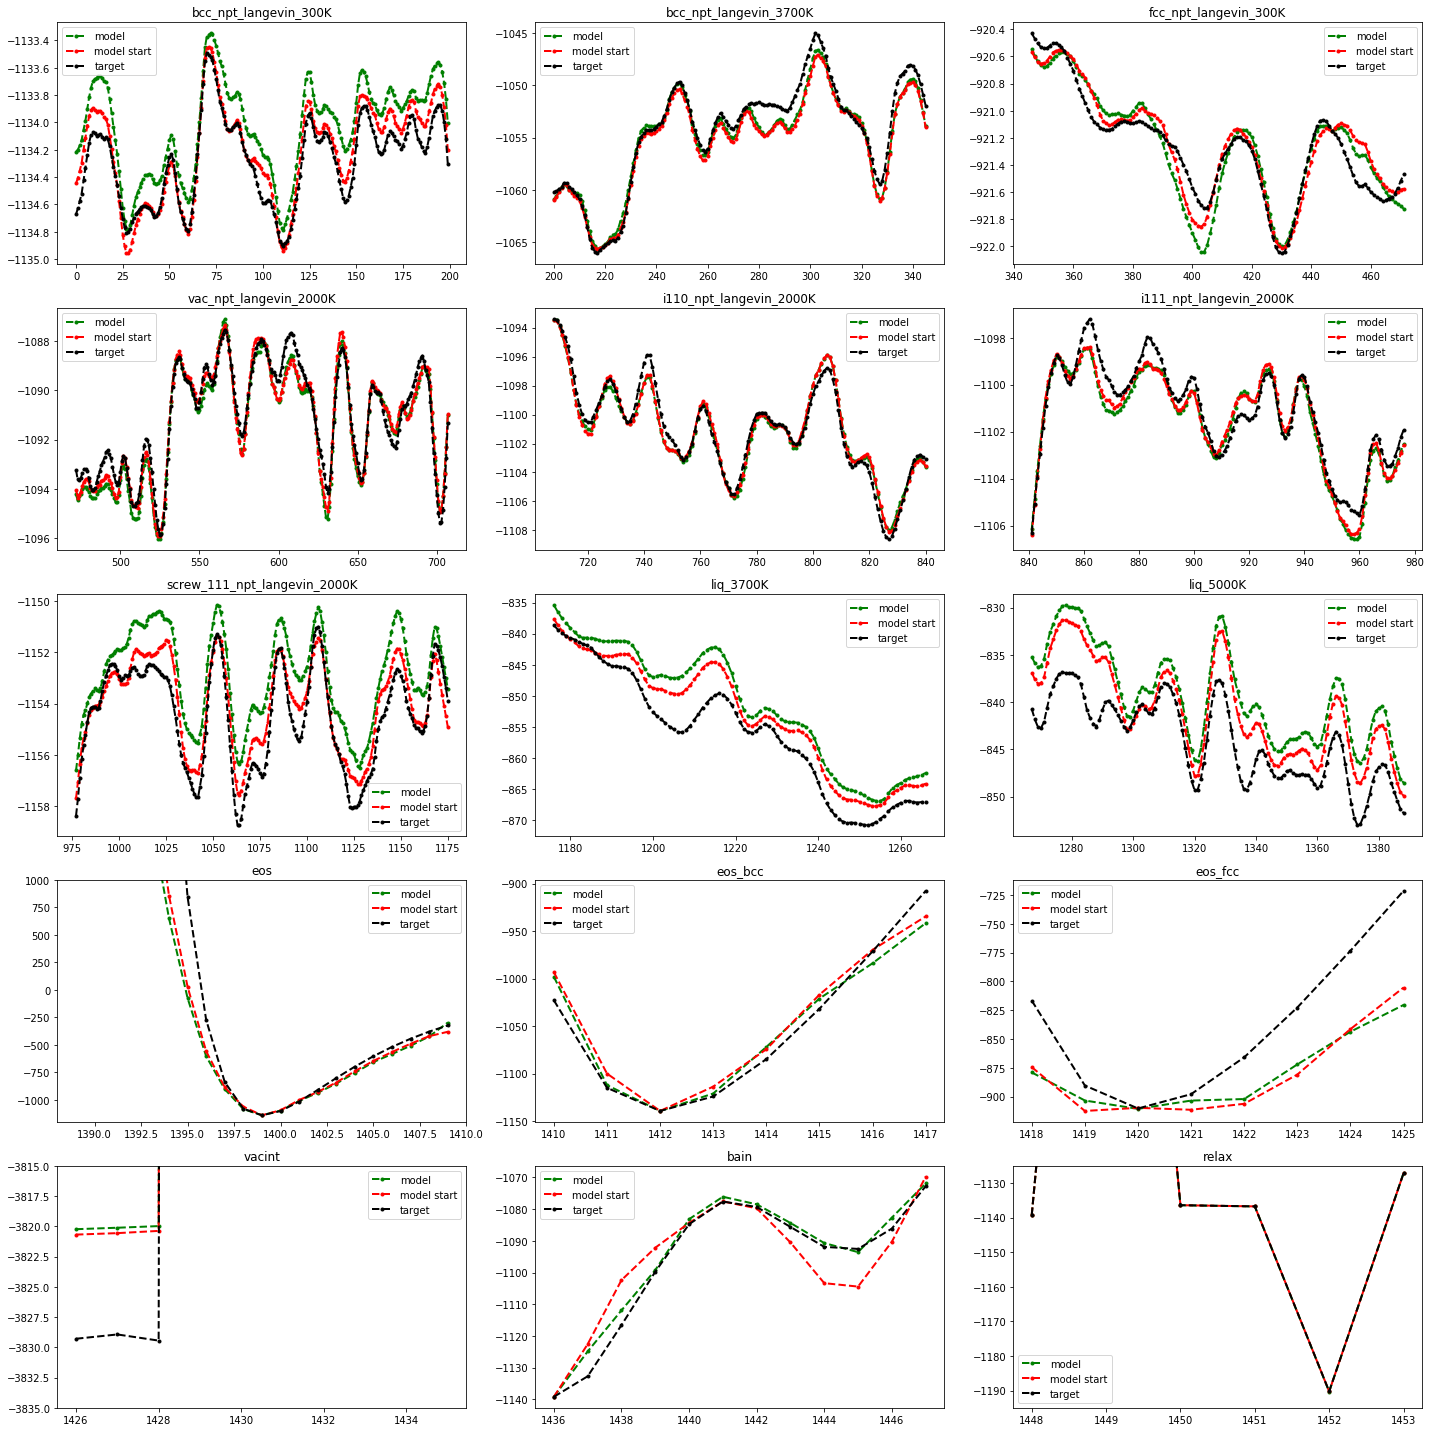

In [560]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(20,20))
    
for k, trj in enumerate(tkeys):
        
    i, j = divmod(k, 3)

    axes[i,j].set_title(trj)
        
    rr = list(range(len(Xall[0])))[bounds[k]][:]

    axes[i,j].plot(rr, energy(b_all, Xall)[bounds[k]][:], 'g.--', lw=2, label='model')
    axes[i,j].plot(rr, energy(b_init, Xall)[bounds[k]][:], 'r.--', lw=2, label='model start')


    axes[i,j].plot(rr, yall[bounds[k],0][:], 'k.--', lw=2, label='target')
    axes[i,j].legend()
    
    if trj == 'relax':
        axes[i,j].set_ylim(-1195, -1125)
        
    if trj == 'vacint':
        axes[i,j].set_ylim(-3835, -3815)
#        axes[i,j].set_xlim(1390,1392)
        
    if trj == 'eos':
        axes[i,j].set_ylim(-1200,1000)
        #axes[i,j].set_xlim(1395,)
    if trj == 'eos':
        axes[i,j].set_ylim(-1200,1000)
        #axes[i,j].set_xlim(1395,)
        
    #axes[i,j].set_xlim(*bounds[k][0])
    #axes[i,j].set_ylim(*bounds[k][1])

plt.tight_layout()

In [561]:
p_knots = np.array(pair_knots)+0.4
print(p_knots)
e_knots = np.array(edens_knots)+0.4
print(e_knots)
n_edens = len(e_knots)

[1.45 1.55 1.65 1.75 1.85 1.95 2.05 2.15 2.25 2.35 2.45 2.55 2.65 2.75
 2.85 2.95 3.05 3.15 3.25 3.35 3.45 3.55 3.65 3.75 3.85 3.95 4.05 4.15
 4.25 4.35 4.45 4.55 4.65 4.75 4.85 4.95 5.05 5.15 5.25 5.35 5.45 5.55
 5.65]
[1.45 1.55 1.65 1.75 1.85 1.95 2.05 2.15 2.25 2.35 2.45 2.55 2.65 2.75
 2.85 2.95 3.05 3.15 3.25 3.35 3.45 3.55 3.65 3.75 3.85 3.95 4.05 4.15
 4.25 4.35 4.45 4.55 4.65 4.75 4.85 4.95]


In [562]:
def _bspline_coeffs_to_tpf(n_tot):
    """
    Finds b-spline coefficients reproducing a single cubic
    functin (rc-r)**3
    """

    penalty = [1.0, -4.0, 6.0, -4.0, 1.0]
    o = 4
    P = np.zeros((n_tot+4, n_tot), dtype=float)
    for i in range(n_tot+4):
        #ii = i - 4
        for j, p in enumerate(penalty):
            if i+j-o < 0 or i+j-o > n_tot-1:
                continue
            P[i, i+j-o] = p

    return P

In [563]:
M = _bspline_coeffs_to_tpf(43)

In [564]:
#b11_ext = np.array([4.2e3, 3.6e3, 3.10e3, 2.65e3] + list(b_weight11[2:]))*(6*0.1**3)
b11_ext = np.array(list(b_all[1:-n_edens]))#*(6*0.1**3)
print(b11_ext)
tpf_coeff = M.dot(b11_ext)
print(tpf_coeff)

[ 4.70181796e+03  4.11458248e+03  3.56993897e+03  3.06792563e+03
  2.60855106e+03  2.19164573e+03  1.81701390e+03  1.48436502e+03
  1.19298420e+03  9.41818019e+02  7.29222240e+02  5.52866219e+02
  4.09584875e+02  2.96192141e+02  2.10706212e+02  1.47422155e+02
  9.87493381e+01  6.61617279e+01  4.68800167e+01  3.96301718e+01
  4.16616820e+01  4.82100019e+01  5.43292446e+01  5.70305907e+01
  5.55841240e+01  5.16692275e+01  4.49864828e+01  3.70119009e+01
  2.80557087e+01  1.89617881e+01  1.01263740e+01  4.18213719e+00
  3.73753874e+00  3.30668422e+00  1.50886512e+00  6.53698325e-01
  7.36010489e-01  3.62542892e-02 -1.93852683e+00  3.20298768e-01
 -3.12601605e+00 -1.18901093e+00  8.55034562e-02]
[ 4.70181796e+03 -1.46926894e+04  1.53225168e+04 -5.33160720e+03
 -2.96359611e-02 -1.78071399e-01 -2.62635510e-02 -9.47817401e-02
 -4.24350136e-01 -3.38517967e-01 -5.90834352e-01 -6.86395486e-01
 -8.34439217e-01 -2.09875032e-02  1.20426428e+00 -3.72312982e+00
 -1.88569917e+00  9.06460038e+00 -4.2532

In [565]:
Medens = _bspline_coeffs_to_tpf(36)

In [566]:
#b11_ext = np.array([4.2e3, 3.6e3, 3.10e3, 2.65e3] + list(b_weight11[2:]))*(6*0.1**3)
ed11_ext = np.array(list(b_all[-n_edens:]))#*(6*0.1**3)
print(ed11_ext)
edens_coeff = Medens.dot(ed11_ext)
print(edens_coeff)

[13929.2344703  13661.19095276 13292.29910317 12822.37766178
 12249.69929305 11572.04602187 10785.64877262  9892.69358466
  8906.34751341  7850.63057276  6761.34491463  5686.93057836
  4685.1585842   3799.39944772  3027.54377971  2403.92736429
  1936.1339343   1553.50686216  1300.01690269  1173.80539621
  1122.38760758  1079.56443397  1004.12689996   897.87400012
   777.09038059   635.54749255   505.13798954   370.47997407
   242.02894039   128.89246154    77.35563041    78.0344499
    63.90724653    58.06987196    69.61921329    28.58727421]
[ 1.39292345e+04 -4.20557469e+04  4.22229421e+04 -1.40966109e+04
 -1.54607580e+00 -4.90639560e-01 -1.55110049e+00  5.95511494e+00
  1.09810161e+01  1.08529584e+01  1.17821380e+01  1.26378874e+01
  9.33098092e+00 -1.44005047e+01 -4.54799047e+01  3.64451733e+01
 -2.67520513e+01 -7.82403604e+01  1.14627382e+02 -4.58294145e+01
 -5.06260754e+01 -1.37143677e+01  2.49901274e+01  4.30079700e+01
  1.44856516e+01 -2.25131950e+01  3.81212024e+01 -4.72745510e

In [567]:
p_knot = [1.05, 1.15, 1.25, 1.35] + list(p_knots)
print(len(tpf_coeff), len(p_knot))
e_knot = [1.05, 1.15, 1.25, 1.35] + list(e_knots)
print(len(edens_coeff), len(e_knot))

47 47
40 40


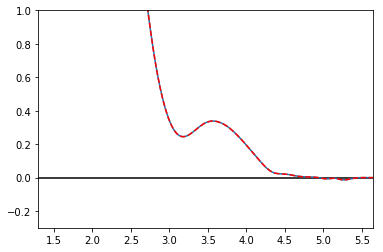

In [568]:
from statmechlib.forcefields import f_embed, f_dens, f_spline3

rr = np.linspace(1.3, 5.65, 436)

plt.plot(rr, [make_bspline(b_all[1:-n_edens], p_knot, r) for r in rr])
plt.xlim(1.3,)

#print(rr)
bs_target = [make_bspline(b_all[1:-n_edens], p_knot, r) for r in rr]
plt.plot(rr, [f_spline3(r, tpf_coeff, p_knot) for r in rr], 'r--')
plt.ylim(-0.3,1)
plt.xlim(rr[0], rr[-1])
plt.hlines(0.0, rr[0], rr[-1])
plt.savefig('pair_potential')

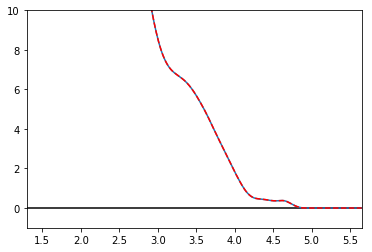

In [569]:
from statmechlib.forcefields import f_embed, f_dens, f_spline3

rr = np.linspace(1.3, 5.65, 436)

plt.plot(rr, [make_bspline(b_all[-n_edens:], p_knot, r) for r in rr])
plt.xlim(1.3,)

#print(rr)
bs_target = [make_bspline(b_all[-n_edens:], e_knot, r) for r in rr]
plt.plot(rr, [f_spline3(r, edens_coeff, e_knot) for r in rr], 'r--')
plt.ylim(-1,10)
#plt.xlim(1.5,2.8)
plt.xlim(rr[0], rr[-1])
plt.hlines(0.0, rr[0], rr[-1])
plt.savefig('pair_potential')

In [570]:
tpf_coeff

array([ 4.70181796e+03, -1.46926894e+04,  1.53225168e+04, -5.33160720e+03,
       -2.96359611e-02, -1.78071399e-01, -2.62635510e-02, -9.47817401e-02,
       -4.24350136e-01, -3.38517967e-01, -5.90834352e-01, -6.86395486e-01,
       -8.34439217e-01, -2.09875032e-02,  1.20426428e+00, -3.72312982e+00,
       -1.88569917e+00,  9.06460038e+00, -4.25327556e+00,  1.50527512e+00,
       -1.47647838e+00, -2.01403413e+00, -1.81341721e-01,  1.95706779e+00,
        2.25890299e+00,  2.40929919e+00, -1.97880130e+00,  1.77542943e+00,
       -1.16578424e+00,  5.33655048e-01, -4.47646999e-01,  2.23643595e+00,
       -2.42097583e-02, -8.09435552e+00,  4.10518594e+00,  3.69032538e+00,
       -2.31479022e+00, -1.71437398e+00,  1.22659077e+00,  6.00158818e+00,
       -1.54473787e+01,  2.10272075e+01, -1.71342710e+01,  5.34828356e+00,
        2.14304841e+00, -1.53102475e+00,  8.55034562e-02])

In [571]:
edens_coeff

array([ 1.39292345e+04, -4.20557469e+04,  4.22229421e+04, -1.40966109e+04,
       -1.54607580e+00, -4.90639560e-01, -1.55110049e+00,  5.95511494e+00,
        1.09810161e+01,  1.08529584e+01,  1.17821380e+01,  1.26378874e+01,
        9.33098092e+00, -1.44005047e+01, -4.54799047e+01,  3.64451733e+01,
       -2.67520513e+01, -7.82403604e+01,  1.14627382e+02, -4.58294145e+01,
       -5.06260754e+01, -1.37143677e+01,  2.49901274e+01,  4.30079700e+01,
        1.44856516e+01, -2.25131950e+01,  3.81212024e+01, -4.72745510e+01,
        2.58373917e+01, -1.34792120e+00,  3.71775199e+01, -5.56690900e+01,
       -5.76376763e+01,  9.01175251e+01, -1.39989645e+01, -7.90648834e+01,
        1.34993942e+02, -4.88833359e+01, -4.47298836e+01,  2.85872742e+01])

In [572]:
params = {
    'hyperparams':{'pair':[], 'edens':[]},
    'params':{'pair':[], 'edens':[]}}
params['hyperparams']['pair'] = p_knot
params['params']['pair'] = tpf_coeff
params['hyperparams']['edens'] = e_knot
params['params']['edens'] = edens_coeff
params['params']['embed'] = [-1.0, b_all[0]]

In [573]:
param_list = [params]
#param_list

In [576]:
file_name = os.path.join(working, "params_final_forces.pickle")

for params in param_list[-1:]:
    params_to_pickle(params, file_name)#, encoding='latin1', protocol=3)

In [577]:
file_name = os.path.join(working, "params_final_forces.pickle")

with open(file_name, 'rb') as fi:
    params_store = pickle.load(fi)
#params_store[-1]

In [578]:
print('pair')

for c, k in zip(tpf_coeff, p_knot):
    if c > 0.0:
        print('+{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, round(k, 2)))
    else:
        print('{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, round(k, 2)))

print('edens') 
for c, k in zip(edens_coeff, e_knot):
    if c > 0.0:
        print('+{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, round(k, 2)))
    else:
        print('{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, round(k, 2)))
        
print('embed')
print(-1.0, b_all[0])
#print(-4.42166597e-01,  1.12818607e-04)
#print(-4.49779872e-01,  1.09664665e-04)

pair
+4701.817959191992d0*(1.05d0 - r)**3*H(1.05d0 - r)
-14692.689359697128d0*(1.15d0 - r)**3*H(1.15d0 - r)
+15322.516812338035d0*(1.25d0 - r)**3*H(1.25d0 - r)
-5331.607202547126d0*(1.35d0 - r)**3*H(1.35d0 - r)
-0.029635961067469907d0*(1.45d0 - r)**3*H(1.45d0 - r)
-0.17807139896012814d0*(1.55d0 - r)**3*H(1.55d0 - r)
-0.026263551048941736d0*(1.65d0 - r)**3*H(1.65d0 - r)
-0.09478174013929674d0*(1.75d0 - r)**3*H(1.75d0 - r)
-0.42435013604244887d0*(1.85d0 - r)**3*H(1.85d0 - r)
-0.33851796686212765d0*(1.95d0 - r)**3*H(1.95d0 - r)
-0.5908343524070006d0*(2.05d0 - r)**3*H(2.05d0 - r)
-0.6863954863258641d0*(2.15d0 - r)**3*H(2.15d0 - r)
-0.8344392170583887d0*(2.25d0 - r)**3*H(2.25d0 - r)
-0.020987503247170025d0*(2.35d0 - r)**3*H(2.35d0 - r)
+1.2042642817093565d0*(2.45d0 - r)**3*H(2.45d0 - r)
-3.7231298243415267d0*(2.55d0 - r)**3*H(2.55d0 - r)
-1.8856991704445818d0*(2.65d0 - r)**3*H(2.65d0 - r)
+9.064600375369196d0*(2.75d0 - r)**3*H(2.75d0 - r)
-4.253275563553018d0*(2.85d0 - r)**3*H(2.85d0 - r)
+

In [ ]:
par = param_list[2]
print('pair')
for c, k in zip(par['params']['pair'], par['hyperparams']['pair']):
    if c > 0.0:
        print('+{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, k))
    else:
        print('{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, k))
print('edens')   
for c, k in zip(par['params']['edens'], par['hyperparams']['edens']):
    if c > 0.0:
        print('+{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, k))
    else:
        print('{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, k))
print('embed')    
par['params']['embed']